In [1]:
# ---------------------------------------------------------------------------------
#                                 _             _      
#                                | |_  ___ _ __(_)__ _ 
#                                | ' \/ -_) '_ \ / _` |
#                                |_||_\___| .__/_\__,_|
#                                         |_|          
#
#---------------------------------------------------------------------------------
#
# Company: HEPIA // HES-SO
# Engineer: Laurent Gantel <laurent.gantel@hesge.ch>
# 
# Project Name: Unleashing the Full Potential of 
#               High-Performance Cherenkov Telescopes
#               with Fully-Digital Solid-State Sensors Camera
#
# File: 0.0_parse_data.ipynb
# Description: Notebook for parsing calibrated data
#
# Last update: 2025-08-25
#
#--------------------------------------------------------------------------------

In [2]:
import os
import sys
import importlib
import numpy as np
from astropy import units as u
from matplotlib import pyplot as plt

import ctapipe
from ctapipe.calib import CameraCalibrator
from ctapipe.image import hillas_parameters, tailcuts_clean
from ctapipe.io import EventSource
from ctapipe.utils.datasets import get_dataset_path
from ctapipe.visualization import ArrayDisplay, CameraDisplay

# %matplotlib inline
plt.style.use("ggplot")

print(ctapipe.__version__)
print(ctapipe.__file__)

0.24.0
/home/hugo/miniforge3/envs/ctlearn/lib/python3.10/site-packages/ctapipe/__init__.py


In [3]:
# Custom tools
tools_path = os.path.join("../tools")
if tools_path not in sys.path:
    sys.path.append(tools_path)

import tools.CTLearnMgrConfig as CTLearnMgrConfig
importlib.reload(CTLearnMgrConfig)
import tools.SimtelDataHandler as SimtelDataHandler
importlib.reload(SimtelDataHandler)

<module 'tools.SimtelDataHandler' from '/home/hugo/TM/ml/tools/SimtelDataHandler.py'>

In [4]:
ctlearn_mgr_config = CTLearnMgrConfig.CTLearnMgrConfig()
ctlearn_mgr_config.load_config('../config/ctlearnmgr_config.yml')
ctlearn_mgr_config.print_config()

# Create the model index file
ctlearn_mgr_config.create_model_index_file()

Base Directory: /home/hugo/TM
Simtel Relative Directory: data
Training Samples Directory: samples
Workspace Directory: ml
Simtel Path: /home/hugo/TM/data
Training Samples Path: /home/hugo/TM/data/samples
Workspace Path: /home/hugo/TM/ml
Model Index File: /home/hugo/TM/ml/ctlearn_models_index.h5
Model index file already exists at: /home/hugo/TM/ml/ctlearn_models_index.h5


In [46]:
# Open raw event file and get an event out of it
gammas_dir = os.path.join(ctlearn_mgr_config.training_samples_path, 'gamma', 'train')
gammas_filename = 'gamma_200_800E3GeV_20_20deg_ATM52_100506.corsika.gz.NSBmed4.simtel.gz'
gammas_path = os.path.join(gammas_dir, gammas_filename)
source = EventSource(gammas_path, max_events=15)

id = 5909
wanted_event = None
for event in source:

    print(event.index.event_id)
    if event.index.event_id == id:
        wanted_event = event

1312
3202
3216
3805
5905
5909
5916
9100
12105
13408
13415
13519
14901
14912
14913


In [47]:
print(wanted_event.r1)

{'tel': {1: {'calibration_monitoring_id': None,
             'event_time': <Time object: scale='tai' format='mjd' value=0.0>,
             'event_type': <EventType.SUBARRAY: 32>,
             'first_cell_id': None,
             'module_hires_local_clock_counter': None,
             'pedestal_intensity': None,
             'pixel_status': array([4, 4, 4, ..., 4, 4, 4], dtype=uint8),
             'selected_gain_channel': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
             'waveform': array([[[-0.24591482, -0.34563252, -0.29577366, ...,  0.05323825,
          0.25267363,  0.3025325 ],
        [ 0.05760892,  0.05760892,  0.00844803, ...,  0.05760892,
         -0.04071286, -0.08987375],
        [-0.10194897,  0.04258717,  0.1389446 , ...,  0.6207317 ,
          0.5243743 ,  0.42801687],
        ...,
        [-0.24011174, -0.24011174, -0.24011174, ...,  0.14188474,
         -0.00136394, -0.14461263],
        [ 0.08710303,  0.1834975 ,  0.27989197, ...,  0.37628645,
          0.37628645,

In [48]:
######################################################################
# Perform basic calibration:
# --------------------------
#
# Here we will use a ``CameraCalibrator`` which is just a simple wrapper
# that runs the three calibraraton and trace-integration phases of the
# pipeline, taking the data from levels:
#
# **R0** → **R1** → **DL0** → **DL1**
#
# You could of course do these each separately, by using the classes
# ``R1Calibrator``, ``DL0Reducer``, and ``DL1Calibrator``. Note that we
# have not specified any configuration to the ``CameraCalibrator``, so it
# will be using the default algorithms and thresholds, other than
# specifying that the product is a “HESSIOR1Calibrator” (hopefully in the
# near future that will be automatic).
#


calib = CameraCalibrator(subarray=source.subarray)
calib(wanted_event)

In [49]:
######################################################################
# Now the *r1*, *dl0* and *dl1* containers are filled in the event
#
# -  **r1.tel[x]**: contains the “r1-calibrated” waveforms, after
#    gain-selection, pedestal subtraction, and gain-correction
# -  **dl0.tel[x]**: is the same but with optional data volume reduction
#    (some pixels not filled), in this case this is not performed by
#    default, so it is the same as r1
# -  **dl1.tel[x]**: contains the (possibly re-calibrated) waveforms as
#    dl0, but also the time-integrated *image* that has been calculated
#    using a ``ImageExtractor`` (a ``NeighborPeakWindowSum`` by default)
#

for tel_id in event.dl1.tel:
    print("TEL{:03}: {}".format(tel_id, source.subarray.tel[tel_id]))
    print("  - r0  wave shape  : {}".format(event.r0.tel[tel_id].waveform.shape))
    print("  - r1  wave shape  : {}".format(event.r1.tel[tel_id].waveform.shape))
    print("  - dl1 image shape : {}".format(event.dl1.tel[tel_id].image.shape))

In [50]:
# Look at the image
tel_id = sorted(wanted_event.r1.tel.keys())[0]
sub = source.subarray
geometry = sub.tel[tel_id].camera.geometry

image = wanted_event.dl1.tel[tel_id].image
#image = event.r1.tel[tel_id].waveform[0].T[0]
print(f"Get image from tel {tel_id} with shape {image.shape}")

Get image from tel 1 with shape (1296,)


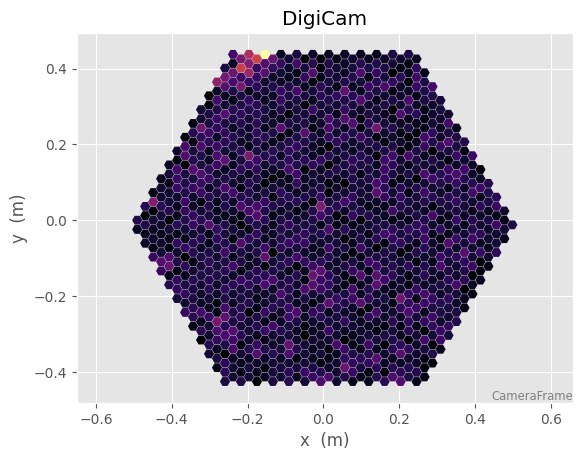

In [51]:
disp = CameraDisplay(geometry, image=image)

In [45]:
print(event)

{'calibration': {'tel': {1: {'dl1': {'absolute_factor': 1,
                                     'pedestal_offset': None,
                                     'relative_factor': 1,
                                     'time_shift': array([ 1.775518e-04, -1.368540e-04,  6.616109e-05, ..., -4.238431e-04,
        3.256180e-04, -7.540249e-05], dtype=float32)}}}},
 'count': 0,
 'dl0': {'tel': {1: {'selected_gain_channel': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
                     'waveform': array([[ 0.05323825, -0.09633828, -0.04647944, ...,  0.40225017,
         0.20281479, -0.04647944],
       [ 0.2542525 ,  0.35257426,  0.10676981, ..., -0.3356782 ,
        -0.434     , -0.28651732],
       [ 0.18712331,  0.23530203,  0.18712331, ...,  0.42801687,
         0.04258717, -0.1983064 ],
       ...,
       [ 0.14188474, -0.0491135 , -0.19236217, ..., -0.38336042,
        -0.43111   , -0.2878613 ],
       [-0.2502776 , -0.29847485, -0.20208038, ..., -0.05748868,
        -0.15388314, -0.29